### Problem Statement

    Identify products at risk of backorder before the event occurs so that business has time to react.

### What is a Backorder?
    Backorders are products that are temporarily out of stock, but a customer is permitted to place an order against future inventory. A backorder generally indicates that customer demand for a product or service exceeds a company’s capacity to supply it. Back orders are both good and bad. Strong demand can drive back orders, but so can suboptimal planning.

### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.

#### Identify Right Error Metrics

    Based on the businees, identify right error metrics.

### Data Pre-processing
#### Loading the required libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score 
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

In [4]:
tf.__version__

'2.1.0'

###### fix random seed for reproducibility

    Generally, Keras gets its source of randomness from the NumPy random number generator.
    
    In addition, TensorFlow has its own random number generator that must also be seeded by calling the set_random_seed() function immediately after the NumPy random number generator, as follows:

In [5]:
np.random.seed(123)

tf.random.set_seed(123)

#### Loading the data

In [6]:
data = pd.read_csv("/home/datasets/lab/Batch85/DeepLearning/MLP/BackOrders.csv",header=0)

#### Understand the Data

See the number row and columns

In [7]:
data.shape

(61589, 23)

Display the columns

In [8]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

__See the top rows of the data__

In [9]:
data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


__Shows a quick statistic summary of your data using describe__

In [10]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


__Display data type of each variable__

In [11]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

    sku is Categorical but is interpreted as int64 

    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [12]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [13]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

##### Delete sku attribute

In [14]:
np.size(np.unique(data.sku))

61589

In [15]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

In [16]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

### Preparing Data for Model building

In [17]:
data['went_on_backorder'] = data['went_on_backorder'].replace(to_replace=['No', 'Yes'], value=[0, 1])
data['went_on_backorder'].value_counts()

0    50296
1    11293
Name: went_on_backorder, dtype: int64

In [18]:
X, y = data.loc[:,data.columns!='went_on_backorder'], data.loc[:,'went_on_backorder']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=123, stratify = y)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(43112, 21)
(43112,)
(18477, 21)
(18477,)


In [20]:
X_train.dtypes

national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
dtype: object

In [21]:
cat_attr = list(X_train.select_dtypes(include=['category']).columns)
num_attr = list(X_train.select_dtypes(include=['number']).columns)

In [22]:
print(cat_attr)
print(num_attr)

['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']
['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']


#### Handling Numerical Columns

##### Imputation

In [23]:
imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(X_train[num_attr])

X_train[num_attr] = imputer.transform(X_train[num_attr])
X_val[num_attr] = imputer.transform(X_val[num_attr])

In [24]:
X_train.isnull().sum()

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
dtype: int64

In [25]:
X_val.isnull().sum()

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
dtype: int64

##### Standardize the data 


In [26]:
scaler = StandardScaler()
scaler.fit(X_train[num_attr])

StandardScaler()

In [27]:
scaler.mean_

array([280.39807942,   7.58475598,  31.7570746 , 180.32192893,
       333.50714418, 478.5932223 ,  48.70351642, 168.15587307,
       311.69379755, 459.47599276,  45.86509557,   1.33239005,
        -6.23209338,  -5.79506425,   1.13017257])

In [28]:
scaler.var_

array([1.65743285e+07, 3.96771734e+01, 8.41446996e+05, 3.84987183e+07,
       1.30909776e+08, 2.76547320e+08, 2.64594279e+06, 3.85766961e+07,
       1.10699939e+08, 2.26680875e+08, 1.26537112e+06, 7.44504380e+02,
       6.49465857e+02, 6.11292307e+02, 8.74380578e+02])

In [29]:
X_train_num = pd.DataFrame(scaler.transform(X_train[num_attr]), columns=num_attr)
X_val_num = pd.DataFrame(scaler.transform(X_val[num_attr]), columns=num_attr)

In [30]:
print(X_train_num.shape)
print(X_val_num.shape)

print(type(X_train_num))
print(type(X_val_num))

(43112, 15)
(18477, 15)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


#### Handling Categorical Columns
##### Imputation

In [31]:
imputer = SimpleImputer(strategy='most_frequent')

imputer = imputer.fit(X_train[cat_attr])

X_train[cat_attr] = imputer.transform(X_train[cat_attr])
X_val[cat_attr] = imputer.transform(X_val[cat_attr])

##### One Hot Encoding

In [32]:
ohe = OneHotEncoder(handle_unknown='error')

In [33]:
ohe.fit(X_train[cat_attr])

columns_ohe = list(ohe.get_feature_names(cat_attr))
print(columns_ohe)

X_train_cat = ohe.transform(X_train[cat_attr])
X_val_cat = ohe.transform(X_val[cat_attr])

X_train_cat = pd.DataFrame(X_train_cat.todense(), columns=columns_ohe)
X_val_cat = pd.DataFrame(X_val_cat.todense(), columns=columns_ohe)

['potential_issue_No', 'potential_issue_Yes', 'deck_risk_No', 'deck_risk_Yes', 'oe_constraint_No', 'oe_constraint_Yes', 'ppap_risk_No', 'ppap_risk_Yes', 'stop_auto_buy_No', 'stop_auto_buy_Yes', 'rev_stop_No', 'rev_stop_Yes']


In [34]:
print(X_train_cat.shape)
print(X_val_cat.shape)

print(type(X_train_cat))
print(type(X_val_cat))

(43112, 12)
(18477, 12)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### Merging of Numerical and Categorical Dataframes

In [35]:
X_train_proc = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_proc = pd.concat([X_val_num, X_val_cat], axis=1)

In [36]:
print(X_train_proc.shape)
print(y_train.shape)
print(X_val_proc.shape)
print(y_val.shape)

(43112, 27)
(43112,)
(18477, 27)
(18477,)


In [37]:
y_train

32557    0
35028    0
18       1
24527    0
54999    0
        ..
27190    0
55221    0
2605     1
35193    1
15355    0
Name: went_on_backorder, Length: 43112, dtype: int64

### Convert dataframe to numpy array to feed into Neural Networks

In [38]:
print(type(X_train_proc))
print(type(X_val_proc))

X_train_proc_arr = X_train_proc.values
X_val_proc_arr = X_val_proc.values

print(type(X_train_proc_arr))
print(type(X_val_proc_arr))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Perceptron Model

In [39]:
perceptron_model = Sequential()
perceptron_model.add(Dense(1, activation='sigmoid', input_shape=(27,)))

In [40]:
perceptron_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[tf.keras.metrics.Recall()])

In [41]:
perceptron_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [42]:
perceptron_model_history = perceptron_model.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2)


Train on 34489 samples, validate on 8623 samples
Epoch 1/100
34489/34489 [==============================] - 2s 57us/sample - loss: 0.4987 - recall: 0.0444 - val_loss: 0.4729 - val_recall: 0.0025
Epoch 2/100
34489/34489 [==============================] - 1s 37us/sample - loss: 0.4646 - recall: 0.0065 - val_loss: 0.4680 - val_recall: 0.0025
Epoch 3/100
34489/34489 [==============================] - 1s 36us/sample - loss: 0.4617 - recall: 0.0068 - val_loss: 0.4656 - val_recall: 0.0037
Epoch 4/100
34489/34489 [==============================] - 1s 41us/sample - loss: 0.4603 - recall: 0.0076 - val_loss: 0.4649 - val_recall: 0.0050
Epoch 5/100
34489/34489 [==============================] - 1s 37us/sample - loss: 0.4595 - recall: 0.0082 - val_loss: 0.4646 - val_recall: 0.0056
Epoch 6/100
34489/34489 [==============================] - 1s 40us/sample - loss: 0.4590 - recall: 0.0086 - val_loss: 0.4645 - val_recall: 0.0056
Epoch 7/100
34489/34489 [==============================] - 1s 36us/sample -

##### Plot

In [43]:
print(perceptron_model_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


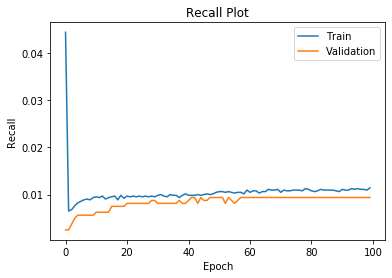

In [44]:
plt.plot(perceptron_model_history.history['recall'])
plt.plot(perceptron_model_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

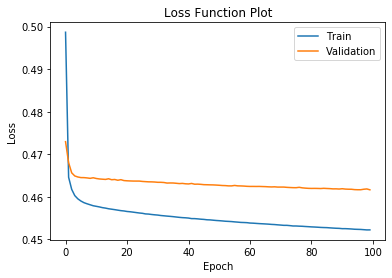

In [45]:
plt.plot(perceptron_model_history.history['loss'])
plt.plot(perceptron_model_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

##### Predictions

In [46]:
val_pred = perceptron_model.predict_classes(X_val_proc_arr)
train_pred = perceptron_model.predict_classes(X_train_proc_arr)

confusion_matrix_val = confusion_matrix(y_val, val_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[35162    45]
 [ 7820    85]]
[[15060    29]
 [ 3346    42]]


##### Train Test Accuracy, True Negative Rate and True Positive Rate

In [47]:
accuracy_score_train = accuracy_score(y_train, train_pred)
accuracy_score_val = accuracy_score(y_val, val_pred)

recall_score_train = recall_score(y_train, train_pred)
recall_score_val = recall_score(y_val, val_pred)

precision_score_train = precision_score(y_train, train_pred)
precision_score_val = precision_score(y_val, val_pred)

print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8175681944702171
Train Recall:  0.010752688172043012
Train Precision:  0.6538461538461539
-----------------------
Val Accuracy:  0.8173404773502192
Val Recall:  0.012396694214876033
Val Precision:  0.5915492957746479


### MLP with 2 layers

    1 hidden layer with 15 neurons

In [48]:
mlp_model1 = Sequential()

mlp_model1.add(Dense(15, activation='tanh', kernel_initializer='normal', input_shape=(27,)))
mlp_model1.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [49]:
mlp_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 436
Trainable params: 436
Non-trainable params: 0
_________________________________________________________________


In [50]:
mlp_model1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[tf.keras.metrics.Recall(name='recall')])


In [51]:
model1_history = mlp_model1.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 34489 samples, validate on 8623 samples
Epoch 1/100
34489/34489 [==============================] - 1s 37us/sample - loss: 0.5304 - recall: 1.5860e-04 - val_loss: 0.4787 - val_recall: 0.0000e+00
Epoch 2/100
34489/34489 [==============================] - 1s 25us/sample - loss: 0.4727 - recall: 1.5860e-04 - val_loss: 0.4751 - val_recall: 6.2500e-04
Epoch 3/100
34489/34489 [==============================] - 1s 27us/sample - loss: 0.4702 - recall: 0.0016 - val_loss: 0.4734 - val_recall: 0.0019
Epoch 4/100
34489/34489 [==============================] - 1s 27us/sample - loss: 0.4682 - recall: 0.0027 - val_loss: 0.4717 - val_recall: 0.0025
Epoch 5/100
34489/34489 [==============================] - 1s 38us/sample - loss: 0.4666 - recall: 0.0035 - val_loss: 0.4703 - val_recall: 0.0031
Epoch 6/100
34489/34489 [==============================] - 1s 40us/sample - loss: 0.4651 - recall: 0.0040 - val_loss: 0.4691 - val_recall: 0.0031
Epoch 7/100
34489/34489 [==============================] - 

##### Plot

In [52]:
print(model1_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


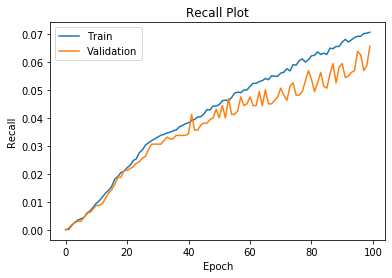

In [53]:
plt.plot(model1_history.history['recall'])
plt.plot(model1_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

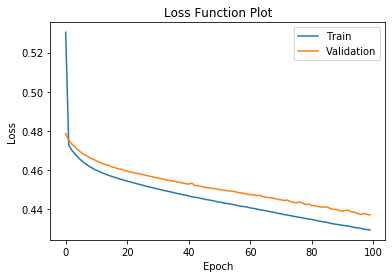

In [54]:
plt.plot(model1_history.history['loss'])
plt.plot(model1_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [55]:
train_model1_pred = mlp_model1.predict_classes(X_train_proc_arr)
val_model1_pred = mlp_model1.predict_classes(X_val_proc_arr)

#### Getting evaluation metrics and evaluating model performance

In [56]:
confusion_matrix_train = confusion_matrix(y_train, train_model1_pred)
confusion_matrix_val = confusion_matrix(y_val, val_model1_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[34963   244]
 [ 7335   570]]
[[14965   124]
 [ 3131   257]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [57]:
accuracy_score_train = accuracy_score(y_train, train_model1_pred)
accuracy_score_val = accuracy_score(y_val, val_model1_pred)

recall_score_train = recall_score(y_train, train_model1_pred)
recall_score_val = recall_score(y_val, val_model1_pred)

precision_score_train = precision_score(y_train, train_model1_pred)
precision_score_val = precision_score(y_val, val_model1_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8242020783076638
Train Recall:  0.07210626185958255
Train Precision:  0.7002457002457002
-----------------------
Val Accuracy:  0.8238350381555447
Val Recall:  0.07585596221959859
Val Precision:  0.6745406824146981


### MLP with 2 layers

    1 hidden layer with 20 neurons

In [58]:
mlp_model2 = Sequential()

mlp_model2.add(Dense(20, input_shape=(27,), activation='sigmoid', kernel_initializer='normal'))
mlp_model2.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [59]:
mlp_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                560       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 581
Trainable params: 581
Non-trainable params: 0
_________________________________________________________________


#### Callbacks - Early Stopping & ModelCheckpoint

In [60]:
import os
cwd = os.getcwd()
cwd

'/home/seemab/AI_and_DecisionSciences/DeepLearning'

In [61]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1, min_delta=0.001)
    
model_checkpoint = ModelCheckpoint(
        os.path.join(cwd, 'mlp_backorders.h5'),
        save_weights_only=True,
        save_best_only=True,
        verbose=1)

In [62]:
callbacks = [early_stopping, model_checkpoint]

In [63]:
mlp_model2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[tf.keras.metrics.Recall(name='recall')])

In [64]:
model2_history = mlp_model2.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks)

Train on 34489 samples, validate on 8623 samples
Epoch 1/100
33024/34489 [===========================>..] - ETA: 0s - loss: 0.4941 - recall: 0.0134
Epoch 00001: val_loss improved from inf to 0.47943, saving model to /home/seemab/AI_and_DecisionSciences/DeepLearning/mlp_backorders.h5
34489/34489 [==============================] - 2s 54us/sample - loss: 0.4935 - recall: 0.0128 - val_loss: 0.4794 - val_recall: 0.0000e+00
Epoch 2/100
32256/34489 [===========================>..] - ETA: 0s - loss: 0.4759 - recall: 0.0000e+00
Epoch 00002: val_loss improved from 0.47943 to 0.47913, saving model to /home/seemab/AI_and_DecisionSciences/DeepLearning/mlp_backorders.h5
34489/34489 [==============================] - 1s 34us/sample - loss: 0.4750 - recall: 0.0000e+00 - val_loss: 0.4791 - val_recall: 0.0000e+00
Epoch 3/100
32320/34489 [===========================>..] - ETA: 0s - loss: 0.4755 - recall: 0.0000e+00
Epoch 00003: val_loss improved from 0.47913 to 0.47886, saving model to /home/seemab/AI_an

##### Plot

In [65]:
print(model2_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


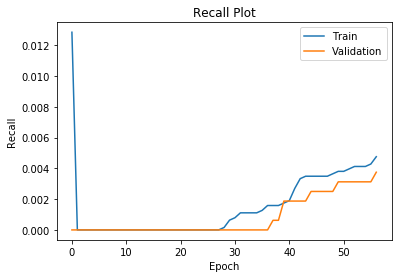

In [66]:
plt.plot(model2_history.history['recall'])
plt.plot(model2_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

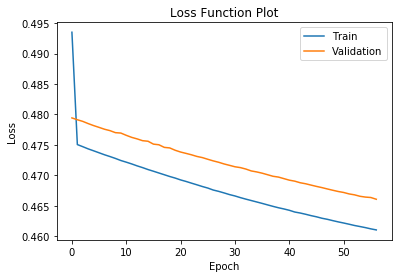

In [67]:
plt.plot(model2_history.history['loss'])
plt.plot(model2_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [68]:
train_model2_pred = mlp_model2.predict_classes(X_train_proc_arr)
val_model2_pred = mlp_model2.predict_classes(X_val_proc_arr)

#### Getting evaluation metrics and evaluating model performance

In [69]:
confusion_matrix_train = confusion_matrix(y_train, train_model2_pred)
confusion_matrix_val = confusion_matrix(y_val, val_model2_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[35174    33]
 [ 7869    36]]
[[15060    29]
 [ 3370    18]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [70]:
accuracy_score_train = accuracy_score(y_train, train_model2_pred)
accuracy_score_val = accuracy_score(y_val, val_model2_pred)

recall_score_train = recall_score(y_train, train_model2_pred)
recall_score_val = recall_score(y_val, val_model2_pred)

precision_score_train = precision_score(y_train, train_model2_pred)
precision_score_val = precision_score(y_val, val_model2_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.816709964742995
Train Recall:  0.004554079696394687
Train Precision:  0.5217391304347826
-----------------------
Val Accuracy:  0.816041565189154
Val Recall:  0.005312868949232586
Val Precision:  0.3829787234042553


### MLP with 2 layers

    1 hidden layer with 25 neurons. activation function - relu 

In [71]:
mlp_model3 = Sequential()

mlp_model3.add(Dense(25, input_shape=(27,), activation='relu', kernel_initializer='normal'))
mlp_model3.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [72]:
mlp_model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 25)                700       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 26        
Total params: 726
Trainable params: 726
Non-trainable params: 0
_________________________________________________________________


In [73]:
mlp_model3.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[tf.keras.metrics.Recall(name='recall')])

In [74]:
model3_history = mlp_model3.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks)

Train on 34489 samples, validate on 8623 samples
Epoch 1/100
34176/34489 [============================>.] - ETA: 0s - loss: 0.5283 - recall: 4.7985e-04
Epoch 00001: val_loss did not improve from 0.46606
34489/34489 [==============================] - 2s 48us/sample - loss: 0.5276 - recall: 4.7581e-04 - val_loss: 0.4761 - val_recall: 0.0000e+00
Epoch 2/100
32960/34489 [===========================>..] - ETA: 0s - loss: 0.4699 - recall: 0.0000e+00
Epoch 00002: val_loss did not improve from 0.46606
34489/34489 [==============================] - 1s 26us/sample - loss: 0.4698 - recall: 0.0000e+00 - val_loss: 0.4729 - val_recall: 0.0000e+00
Epoch 3/100
32448/34489 [===========================>..] - ETA: 0s - loss: 0.4680 - recall: 0.0000e+00
Epoch 00003: val_loss did not improve from 0.46606
34489/34489 [==============================] - 1s 27us/sample - loss: 0.4673 - recall: 0.0000e+00 - val_loss: 0.4711 - val_recall: 0.0000e+00
Epoch 4/100
33408/34489 [============================>.] - ETA:

##### Plot

In [75]:
print(model3_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


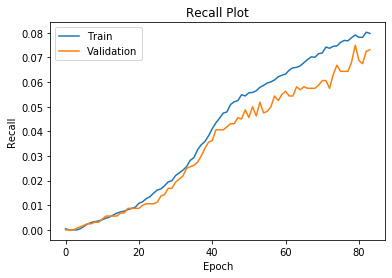

In [76]:
plt.plot(model3_history.history['recall'])
plt.plot(model3_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

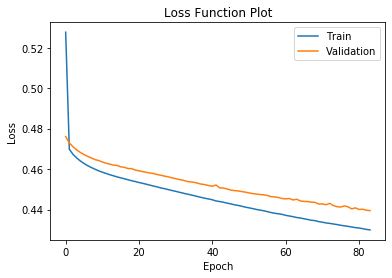

In [77]:
plt.plot(model3_history.history['loss'])
plt.plot(model3_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [78]:
train_model3_pred = mlp_model3.predict_classes(X_train_proc_arr)
val_model3_pred = mlp_model3.predict_classes(X_val_proc_arr)

#### Getting evaluation metrics and evaluating model performance

In [79]:
confusion_matrix_train = confusion_matrix(y_train, train_model3_pred)
confusion_matrix_val = confusion_matrix(y_val, val_model3_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[34927   280]
 [ 7281   624]]
[[14955   134]
 [ 3104   284]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [80]:
accuracy_score_train = accuracy_score(y_train, train_model3_pred)
accuracy_score_val = accuracy_score(y_val, val_model3_pred)

recall_score_train = recall_score(y_train, train_model3_pred)
recall_score_val = recall_score(y_val, val_model3_pred)

precision_score_train = precision_score(y_train, train_model3_pred)
precision_score_val = precision_score(y_val, val_model3_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8246195954722583
Train Recall:  0.07893738140417457
Train Precision:  0.6902654867256637
-----------------------
Val Accuracy:  0.8247551009362992
Val Recall:  0.08382526564344746
Val Precision:  0.6794258373205742


### MLP with 3 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 15 neurons

In [81]:
mlp_model4 = Sequential()

mlp_model4.add(Dense(25, input_shape=(27,), activation='tanh', kernel_initializer='normal'))
mlp_model4.add(Dense(15, activation='tanh', kernel_initializer='normal'))
mlp_model4.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [82]:
mlp_model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 25)                700       
_________________________________________________________________
dense_8 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 16        
Total params: 1,106
Trainable params: 1,106
Non-trainable params: 0
_________________________________________________________________


In [83]:
mlp_model4.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[tf.keras.metrics.Recall(name='recall')])

In [84]:
model4_history = mlp_model4.fit(X_train_proc_arr, y_train, epochs=150, batch_size=64, validation_split=0.2, callbacks=callbacks)

Train on 34489 samples, validate on 8623 samples
Epoch 1/150
33984/34489 [============================>.] - ETA: 0s - loss: 0.5506 - recall: 0.0000e+00
Epoch 00001: val_loss did not improve from 0.43947
34489/34489 [==============================] - 2s 56us/sample - loss: 0.5496 - recall: 0.0000e+00 - val_loss: 0.4912 - val_recall: 0.0000e+00
Epoch 2/150
33216/34489 [===========================>..] - ETA: 0s - loss: 0.4791 - recall: 0.0000e+00
Epoch 00002: val_loss did not improve from 0.43947
34489/34489 [==============================] - 1s 41us/sample - loss: 0.4791 - recall: 0.0000e+00 - val_loss: 0.4796 - val_recall: 0.0000e+00
Epoch 3/150
33856/34489 [============================>.] - ETA: 0s - loss: 0.4751 - recall: 0.0000e+00
Epoch 00003: val_loss did not improve from 0.43947
34489/34489 [==============================] - 1s 41us/sample - loss: 0.4749 - recall: 0.0000e+00 - val_loss: 0.4786 - val_recall: 0.0000e+00
Epoch 4/150
34304/34489 [============================>.] - ETA:

##### Plot

In [85]:
print(model4_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


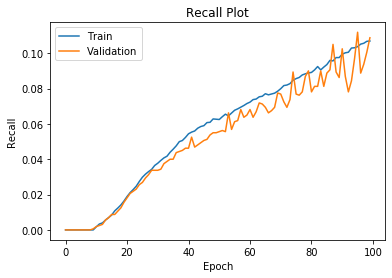

In [86]:
plt.plot(model4_history.history['recall'])
plt.plot(model4_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

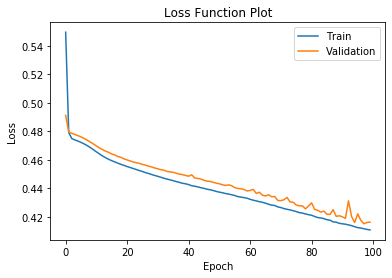

In [87]:
plt.plot(model4_history.history['loss'])
plt.plot(model4_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [88]:
train_model4_pred = mlp_model4.predict_classes(X_train_proc_arr)
val_model4_pred = mlp_model4.predict_classes(X_val_proc_arr)

#### Getting evaluation metrics and evaluating model performance

In [89]:
confusion_matrix_train = confusion_matrix(y_train, train_model4_pred)
confusion_matrix_val = confusion_matrix(y_val, val_model4_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[34826   381]
 [ 6997   908]]
[[14925   164]
 [ 2979   409]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [90]:
accuracy_score_train = accuracy_score(y_train, train_model4_pred)
accuracy_score_val = accuracy_score(y_val, val_model4_pred)

recall_score_train = recall_score(y_train, train_model4_pred)
recall_score_val = recall_score(y_val, val_model4_pred)

precision_score_train = precision_score(y_train, train_model4_pred)
precision_score_val = precision_score(y_val, val_model4_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8288643533123028
Train Recall:  0.1148640101201771
Train Precision:  0.704422032583398
-----------------------
Val Accuracy:  0.8298966282405152
Val Recall:  0.12072018890200709
Val Precision:  0.7137870855148342


### MLP with 3 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 20 neurons

In [91]:
mlp_model5 = Sequential()

mlp_model5.add(Dense(25, input_shape=(27,), activation='relu', kernel_initializer='normal'))
mlp_model5.add(Dense(20, activation='relu', kernel_initializer='normal'))
mlp_model5.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [92]:
mlp_model5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 25)                700       
_________________________________________________________________
dense_11 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
_________________________________________________________________


In [93]:
mlp_model5.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[tf.keras.metrics.Recall(name='recall')])

In [94]:
model5_history = mlp_model5.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks)

Train on 34489 samples, validate on 8623 samples
Epoch 1/100
32960/34489 [===========================>..] - ETA: 0s - loss: 0.5573 - recall: 1.6611e-04
Epoch 00001: val_loss did not improve from 0.41516
34489/34489 [==============================] - 1s 35us/sample - loss: 0.5547 - recall: 1.5860e-04 - val_loss: 0.4967 - val_recall: 0.0000e+00
Epoch 2/100
34176/34489 [============================>.] - ETA: 0s - loss: 0.4823 - recall: 0.0000e+00
Epoch 00002: val_loss did not improve from 0.41516
34489/34489 [==============================] - 1s 20us/sample - loss: 0.4822 - recall: 0.0000e+00 - val_loss: 0.4807 - val_recall: 0.0000e+00
Epoch 3/100
33088/34489 [===========================>..] - ETA: 0s - loss: 0.4758 - recall: 0.0000e+00
Epoch 00003: val_loss did not improve from 0.41516
34489/34489 [==============================] - 1s 21us/sample - loss: 0.4757 - recall: 0.0000e+00 - val_loss: 0.4793 - val_recall: 0.0000e+00
Epoch 4/100
32896/34489 [===========================>..] - ETA:

##### Plot

In [95]:
print(model5_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


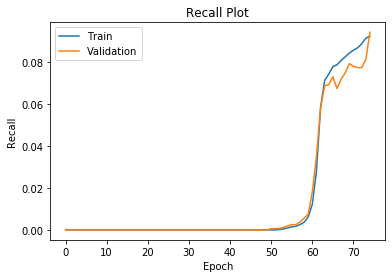

In [96]:
plt.plot(model5_history.history['recall'])
plt.plot(model5_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

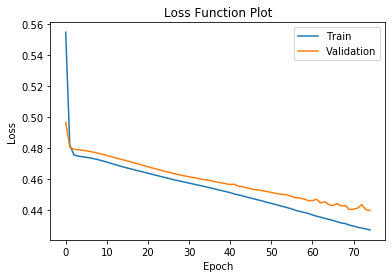

In [97]:
plt.plot(model5_history.history['loss'])
plt.plot(model5_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [98]:
train_model5_pred = mlp_model5.predict_classes(X_train_proc_arr)
val_model5_pred = mlp_model5.predict_classes(X_val_proc_arr)

#### Getting evaluation metrics and evaluating model performance

In [99]:
confusion_matrix_train = confusion_matrix(y_train, train_model5_pred)
confusion_matrix_val = confusion_matrix(y_val, val_model5_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[34816   391]
 [ 7132   773]]
[[14891   198]
 [ 3036   352]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [100]:
accuracy_score_train = accuracy_score(y_train, train_model5_pred)
accuracy_score_val = accuracy_score(y_val, val_model5_pred)

recall_score_train = recall_score(y_train, train_model5_pred)
recall_score_val = recall_score(y_val, val_model5_pred)

precision_score_train = precision_score(y_train, train_model5_pred)
precision_score_val = precision_score(y_val, val_model5_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8255010205975134
Train Recall:  0.09778621125869703
Train Precision:  0.6640893470790378
-----------------------
Val Accuracy:  0.8249715862964767
Val Recall:  0.1038961038961039
Val Precision:  0.64


### MLP with 4 layers

    1st hidden layer with 256 neurons
    2nd hidden layer with 64 neurons
    3rd hidden layer with 8 neurons

In [101]:
mlp_model6 = Sequential()

mlp_model6.add(Dense(256, input_shape=(27,), activation='relu', kernel_initializer='normal'))
mlp_model6.add(Dense(64, activation='relu'))
mlp_model6.add(Dense(8, activation='relu'))
mlp_model6.add(Dense(1, activation='sigmoid'))

In [102]:
mlp_model6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               7168      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 24,145
Trainable params: 24,145
Non-trainable params: 0
_________________________________________________________________


In [103]:
mlp_model6.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[tf.keras.metrics.Recall(name='recall')])

In [104]:
early_stopping = EarlyStopping(monitor='val_recall', patience=5, mode='max', verbose=1)#min_delta=0.001
    
model_checkpoint = ModelCheckpoint(
        os.path.join(cwd, 'mlp_backorders.h5'),
        monitor='val_recall',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1)

In [105]:
callbacks1 = [early_stopping, model_checkpoint]

In [106]:
model6_history = mlp_model6.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks1)

Train on 34489 samples, validate on 8623 samples
Epoch 1/100
32768/34489 [===========================>..] - ETA: 0s - loss: 0.5456 - recall: 0.0219
Epoch 00001: val_recall improved from -inf to 0.00187, saving model to /home/seemab/AI_and_DecisionSciences/DeepLearning/mlp_backorders.h5
34489/34489 [==============================] - 2s 48us/sample - loss: 0.5421 - recall: 0.0209 - val_loss: 0.4755 - val_recall: 0.0019
Epoch 2/100
34304/34489 [============================>.] - ETA: 0s - loss: 0.4676 - recall: 0.0029
Epoch 00002: val_recall improved from 0.00187 to 0.00250, saving model to /home/seemab/AI_and_DecisionSciences/DeepLearning/mlp_backorders.h5
34489/34489 [==============================] - 1s 36us/sample - loss: 0.4675 - recall: 0.0029 - val_loss: 0.4708 - val_recall: 0.0025
Epoch 3/100
32960/34489 [===========================>..] - ETA: 0s - loss: 0.4640 - recall: 0.0033
Epoch 00003: val_recall did not improve from 0.00250
34489/34489 [==============================] - 1s 38

##### Plot

In [107]:
print(model6_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


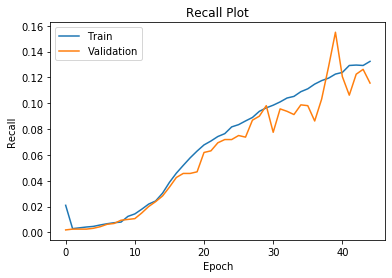

In [108]:
plt.plot(model6_history.history['recall'])
plt.plot(model6_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

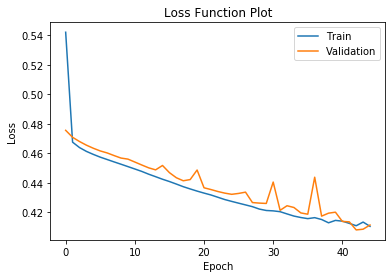

In [109]:
plt.plot(model6_history.history['loss'])
plt.plot(model6_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [110]:
train_model6_pred = mlp_model6.predict_classes(X_train_proc_arr)
val_model6_pred = mlp_model6.predict_classes(X_val_proc_arr)

#### Getting evaluation metrics and evaluating model performance

In [111]:
confusion_matrix_train = confusion_matrix(y_train, train_model6_pred)
confusion_matrix_val = confusion_matrix(y_val, val_model6_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[34799   408]
 [ 6948   957]]
[[14907   182]
 [ 2966   422]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [112]:
accuracy_score_train = accuracy_score(y_train, train_model6_pred)
accuracy_score_val = accuracy_score(y_val, val_model6_pred)

recall_score_train = recall_score(y_train, train_model6_pred)
recall_score_val = recall_score(y_val, val_model6_pred)

precision_score_train = precision_score(y_train, train_model6_pred)
precision_score_val = precision_score(y_val, val_model6_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8293746520690295
Train Recall:  0.12106261859582543
Train Precision:  0.701098901098901
-----------------------
Val Accuracy:  0.8296260215402933
Val Recall:  0.12455726092089728
Val Precision:  0.6986754966887417


### MLP with 4 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 20 neurons
    3rd hidden layer with 15 neurons

In [113]:
mlp_model7 = Sequential()

mlp_model7.add(Dense(25, input_shape=(27,), activation='tanh', kernel_initializer='normal'))
mlp_model7.add(Dense(20, activation='tanh',kernel_initializer='normal'))
mlp_model7.add(Dense(15, activation='tanh',kernel_initializer='normal'))
mlp_model7.add(Dense(1, activation='sigmoid'))

In [114]:
mlp_model7.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 25)                700       
_________________________________________________________________
dense_18 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_19 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 16        
Total params: 1,551
Trainable params: 1,551
Non-trainable params: 0
_________________________________________________________________


In [115]:
mlp_model7.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[tf.keras.metrics.Recall(name='recall')])

In [116]:
%%time
model7_history = mlp_model7.fit(X_train_proc_arr, 
                                y_train, 
                                epochs=100, 
                                batch_size=64, 
                                validation_split=0.2)

Train on 34489 samples, validate on 8623 samples
Epoch 1/100
34489/34489 [==============================] - 2s 57us/sample - loss: 0.5063 - recall: 0.0000e+00 - val_loss: 0.4798 - val_recall: 0.0000e+00
Epoch 2/100
34489/34489 [==============================] - 1s 33us/sample - loss: 0.4754 - recall: 0.0000e+00 - val_loss: 0.4792 - val_recall: 0.0000e+00
Epoch 3/100
34489/34489 [==============================] - 1s 31us/sample - loss: 0.4747 - recall: 0.0000e+00 - val_loss: 0.4786 - val_recall: 0.0000e+00
Epoch 4/100
34489/34489 [==============================] - 1s 30us/sample - loss: 0.4741 - recall: 0.0000e+00 - val_loss: 0.4779 - val_recall: 0.0000e+00
Epoch 5/100
34489/34489 [==============================] - 1s 26us/sample - loss: 0.4733 - recall: 0.0000e+00 - val_loss: 0.4770 - val_recall: 0.0000e+00
Epoch 6/100
34489/34489 [==============================] - 1s 25us/sample - loss: 0.4723 - recall: 0.0000e+00 - val_loss: 0.4759 - val_recall: 0.0000e+00
Epoch 7/100
34489/34489 [==

#### Predictions

In [117]:
train_model7_pred = mlp_model7.predict_classes(X_train_proc_arr)
val_model7_pred = mlp_model7.predict_classes(X_val_proc_arr)

#### Getting evaluation metrics and evaluating model performance

In [118]:
### Calculate Accuracy, True Positive Rate and True Negative Rates

accuracy_score_train = accuracy_score(y_train, train_model7_pred)
accuracy_score_val = accuracy_score(y_val, val_model7_pred)

recall_score_train = recall_score(y_train, train_model7_pred)
recall_score_val = recall_score(y_val, val_model7_pred)

precision_score_train = precision_score(y_train, train_model7_pred)
precision_score_val = precision_score(y_val, val_model7_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8327147893857859
Train Recall:  0.14016445287792537
Train Precision:  0.7275114904793172
-----------------------
Val Accuracy:  0.8321156031823348
Val Recall:  0.14049586776859505
Val Precision:  0.7147147147147147


Observation:

    Model 7 performs better with 25, 20 and 15 neurons
    

## Find best parameter

#### Function for creation of model

In [119]:
def model_def(h_activation, o_activation, kernel_init):
    
    model=Sequential()
    
    model.add(Dense(25, 
                           input_shape=(X_train_proc_arr.shape[1], ),  
                           activation=h_activation, 
                           kernel_initializer=kernel_init))
    
    model.add(Dense(15, 
                           activation=h_activation, 
                           kernel_initializer=kernel_init))
    
    model.add(Dense(1, 
                           activation=o_activation, 
                           kernel_initializer=kernel_init))
    
    return model 

#### Store the best parameters

In [120]:
best_params={}

### Find the best Learning rate

    Using logarithmic scale randomly generate values between 0.0001 to 1 

In [121]:
np.random.rand(2)

array([0.69646919, 0.28613933])

In [122]:
-4*np.random.rand(2)

array([-0.90740581, -2.20525908])

In [123]:
10**-4

0.0001

In [124]:
10 ** (-4 * np.random.rand(10))

array([1.32472008e-03, 2.03036519e-02, 1.19383197e-04, 1.82255669e-03,
       1.19198940e-02, 2.70103323e-02, 4.23923933e-02, 1.21283346e-03,
       1.76080402e-02, 5.77149619e-01])

In [125]:
NUM_LR = 10 

lrs = [round(i, 4) for i in list(10 ** (-4 * np.random.rand(NUM_LR)))]

lrs

[0.0256,
 0.0011,
 0.1862,
 0.1987,
 0.0075,
 0.0075,
 0.0029,
 0.0004,
 0.0013,
 0.0036]

In [126]:
%%time
hist_loss = []

for lr in lrs:
    
    np.random.seed(123)
    tf.random.set_seed(123)
    
    lr_model = model_def(h_activation='tanh', 
                         o_activation='sigmoid', 
                         kernel_init='normal')
    
    # Compile model
    sgd = tf.keras.optimizers.SGD(lr=lr)
    
    lr_model.compile(loss='binary_crossentropy', 
                     optimizer=sgd, 
                     metrics=[tf.keras.metrics.Recall(name='recall')])
    
    # Fit the model
    lr_model_history = lr_model.fit(X_train_proc_arr, 
                                    y_train, 
                                    validation_split=0.2, 
                                    epochs=1,
                                    batch_size=64)
    
    hist_loss.append(lr_model_history.history['loss'])

Train on 34489 samples, validate on 8623 samples
34489/34489 [==============================] - 2s 49us/sample - loss: 0.5089 - recall: 0.0021 - val_loss: 0.4789 - val_recall: 0.0000e+00
Train on 34489 samples, validate on 8623 samples
34489/34489 [==============================] - 1s 38us/sample - loss: 0.6660 - recall: 0.0187 - val_loss: 0.6410 - val_recall: 0.0000e+00ss: 0.6677 - recall: 0.02
Train on 34489 samples, validate on 8623 samples
34489/34489 [==============================] - 1s 36us/sample - loss: 0.4739 - recall: 0.0033 - val_loss: 0.4646 - val_recall: 0.0069
Train on 34489 samples, validate on 8623 samples
34489/34489 [==============================] - 1s 38us/sample - loss: 0.4731 - recall: 0.0036 - val_loss: 0.4637 - val_recall: 0.0088
Train on 34489 samples, validate on 8623 samples
34489/34489 [==============================] - 1s 35us/sample - loss: 0.5741 - recall: 0.0040 - val_loss: 0.5124 - val_recall: 0.0000e+00
Train on 34489 samples, validate on 8623 samples

In [127]:
# Get the lr and loss Dataframe
loss_lr = pd.DataFrame([lrs,hist_loss]).T  

#Give the coloumn names
loss_lr.columns=['lr', 'loss']

# Sort the values and reset the index
loss_lr=loss_lr.sort_values('loss').reset_index().drop('index',axis=1)
loss_lr

,lr,loss
0,0.1987,[0.4730855165354951]
1,0.1862,[0.4738786211347756]
2,0.0256,[0.5088603387543917]
3,0.0075,[0.5740568645227407]
4,0.0075,[0.5740568645227407]
5,0.0036,[0.6189098043635195]
6,0.0029,[0.6301866687112514]
7,0.0013,[0.6614847723175904]
8,0.0011,[0.6660425007324282]
9,0.0004,[0.6833506800153739]


In [128]:
# pick the top lr
best_params['best_learning_rate'] = loss_lr.loc[:,'lr'][0]

#### Build model with the best learning rate

In [129]:
np.random.seed(123)
tf.random.set_seed(123)

In [130]:
bst_lr_model = model_def(h_activation='tanh', 
                         o_activation='sigmoid', 
                         kernel_init='normal')

In [131]:
bst_lr_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 25)                700       
_________________________________________________________________
dense_52 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 16        
Total params: 1,106
Trainable params: 1,106
Non-trainable params: 0
_________________________________________________________________


In [132]:
sgd = tf.keras.optimizers.SGD(lr=best_params['best_learning_rate'])

bst_lr_model.compile(loss='binary_crossentropy', 
                     optimizer=sgd, 
                     metrics=[tf.keras.metrics.Recall()])

In [133]:
%%time
bst_lr_model_history = bst_lr_model.fit(X_train_proc_arr, 
                                        y_train, 
                                        epochs=100, 
                                        batch_size=64, 
                                        validation_split=0.2, 
                                        shuffle=True)

Train on 34489 samples, validate on 8623 samples
Epoch 1/100
34489/34489 [==============================] - 1s 40us/sample - loss: 0.4731 - recall_1: 0.0036 - val_loss: 0.4637 - val_recall_1: 0.0088
Epoch 2/100
34489/34489 [==============================] - 1s 23us/sample - loss: 0.4542 - recall_1: 0.0249 - val_loss: 0.4581 - val_recall_1: 0.0331
Epoch 3/100
34489/34489 [==============================] - 1s 21us/sample - loss: 0.4482 - recall_1: 0.0481 - val_loss: 0.4492 - val_recall_1: 0.0450
Epoch 4/100
34489/34489 [==============================] - 1s 24us/sample - loss: 0.4447 - recall_1: 0.0568 - val_loss: 0.4465 - val_recall_1: 0.0463
Epoch 5/100
34489/34489 [==============================] - 1s 24us/sample - loss: 0.4405 - recall_1: 0.0650 - val_loss: 0.4471 - val_recall_1: 0.0506
Epoch 6/100
34489/34489 [==============================] - 1s 22us/sample - loss: 0.4391 - recall_1: 0.0677 - val_loss: 0.4386 - val_recall_1: 0.0556
Epoch 7/100
34489/34489 [==========================

#### Predictions

In [134]:
train_bst_lr_model_pred = bst_lr_model.predict_classes(X_train_proc_arr)
val_bst_lr_model_pred = bst_lr_model.predict_classes(X_val_proc_arr)

#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [135]:
accuracy_score_train = accuracy_score(y_train, train_bst_lr_model_pred)
accuracy_score_val = accuracy_score(y_val, val_bst_lr_model_pred)

recall_score_train = recall_score(y_train, train_bst_lr_model_pred)
recall_score_val = recall_score(y_val, val_bst_lr_model_pred)

precision_score_train = precision_score(y_train, train_bst_lr_model_pred)
precision_score_val = precision_score(y_val, val_bst_lr_model_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8369595472258304
Train Recall:  0.1822896900695762
Train Precision:  0.7183449651046859
-----------------------
Val Accuracy:  0.8363370677057964
Val Recall:  0.1821133412042503
Val Precision:  0.7091954022988506


#### Getting evaluation metrics and evaluating model performance

#### Find the best Batch size 

In [136]:
batch_sizes = [32, 64, 128, 256]

In [137]:
%%time
history=[]

for batch_size in batch_sizes:
    
    np.random.seed(123)
    tf.random.set_seed(123)
    
    bs_model = model_def(h_activation='tanh', 
                         o_activation='sigmoid', 
                         kernel_init='normal')
    
     # Compile model
    sgd = tf.keras.optimizers.SGD(lr=best_params['best_learning_rate'])
    
    bs_model.compile(loss='binary_crossentropy', 
                     optimizer=sgd, 
                     metrics=[tf.keras.metrics.Recall()])
    
    #Fit the model
    bs_model_history = bs_model.fit(X_train_proc_arr, 
                                    y_train, 
                                    batch_size=batch_size, 
                                    epochs=10,
                                    validation_split=0.2, shuffle=True)
    
    history.append(bs_model_history)

Train on 34489 samples, validate on 8623 samples
Epoch 1/10
34489/34489 [==============================] - 3s 77us/sample - loss: 0.4658 - recall_2: 0.0124 - val_loss: 0.4561 - val_recall_2: 0.0338
Epoch 2/10
34489/34489 [==============================] - 2s 56us/sample - loss: 0.4503 - recall_2: 0.0439 - val_loss: 0.4520 - val_recall_2: 0.0450
Epoch 3/10
34489/34489 [==============================] - 2s 62us/sample - loss: 0.4454 - recall_2: 0.0579 - val_loss: 0.4455 - val_recall_2: 0.0475
Epoch 4/10
34489/34489 [==============================] - 2s 59us/sample - loss: 0.4413 - recall_2: 0.0639 - val_loss: 0.4434 - val_recall_2: 0.0506
Epoch 5/10
34489/34489 [==============================] - 2s 63us/sample - loss: 0.4387 - recall_2: 0.0733 - val_loss: 0.4505 - val_recall_2: 0.0531
Epoch 6/10
34489/34489 [==============================] - 2s 62us/sample - loss: 0.4364 - recall_2: 0.0750 - val_loss: 0.4317 - val_recall_2: 0.0631
Epoch 7/10
34489/34489 [==============================] -

###### Summarize history for train loss

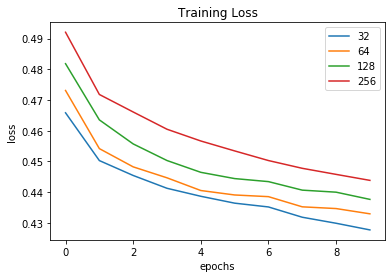

In [138]:
for i in range(0, len(history)):
    plt.plot(history[i].history['loss'])
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epochs')  
plt.legend(batch_sizes, loc='upper right')
plt.show()

###### Summarize history for validation loss

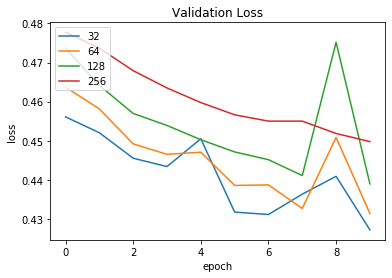

In [139]:
for i in range(0, len(history)):
    plt.plot(history[i].history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')  
plt.legend(batch_sizes, loc='upper left')
plt.show()

#### Build model with the best batch size

In [140]:
best_params['best_batch_size'] = 32

In [141]:
np.random.seed(123)
tf.random.set_seed(123)
    
bst_bs_model = model_def(h_activation='tanh', 
                         o_activation='sigmoid', 
                         kernel_init='normal')

In [142]:
sgd = tf.keras.optimizers.SGD(lr=best_params['best_learning_rate'])

bst_bs_model.compile(loss='binary_crossentropy', 
                     optimizer=sgd, 
                     metrics=[tf.keras.metrics.Recall()])

In [143]:
%%time
bst_bs_model_history = bst_bs_model.fit(X_train_proc_arr, 
                                        y_train, 
                                        epochs=100, 
                                        batch_size=best_params['best_batch_size'],
                                        validation_split=0.2, 
                                        shuffle=True)

Train on 34489 samples, validate on 8623 samples
Epoch 1/100
34489/34489 [==============================] - 3s 76us/sample - loss: 0.4658 - recall_6: 0.0124 - val_loss: 0.4561 - val_recall_6: 0.0338
Epoch 2/100
34489/34489 [==============================] - 2s 52us/sample - loss: 0.4503 - recall_6: 0.0439 - val_loss: 0.4520 - val_recall_6: 0.0450
Epoch 3/100
34489/34489 [==============================] - 2s 58us/sample - loss: 0.4454 - recall_6: 0.0579 - val_loss: 0.4455 - val_recall_6: 0.0475
Epoch 4/100
34489/34489 [==============================] - 2s 58us/sample - loss: 0.4413 - recall_6: 0.0639 - val_loss: 0.4434 - val_recall_6: 0.0506
Epoch 5/100
34489/34489 [==============================] - 2s 60us/sample - loss: 0.4387 - recall_6: 0.0733 - val_loss: 0.4505 - val_recall_6: 0.0531
Epoch 6/100
34489/34489 [==============================] - 2s 64us/sample - loss: 0.4364 - recall_6: 0.0750 - val_loss: 0.4317 - val_recall_6: 0.0631
Epoch 7/100
34489/34489 [==========================

#### Predictions

In [144]:
train_bst_bs_model_pred = bst_bs_model.predict_classes(X_train_proc_arr)
val_bst_bs_model_pred = bst_bs_model.predict_classes(X_val_proc_arr)

#### Getting evaluation metrics and evaluating model performance

In [145]:
### Calculate Accuracy, True Positive Rate and True Negative Rates

accuracy_score_train = accuracy_score(y_train, train_bst_bs_model_pred)
accuracy_score_val = accuracy_score(y_val, val_bst_bs_model_pred)

recall_score_train = recall_score(y_train, train_bst_bs_model_pred)
recall_score_val = recall_score(y_val, val_bst_bs_model_pred)

precision_score_train = precision_score(y_train, train_bst_bs_model_pred)
precision_score_val = precision_score(y_val, val_bst_bs_model_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8383744665058452
Train Recall:  0.1728020240354206
Train Precision:  0.7610027855153203
-----------------------
Val Accuracy:  0.8371488878064621
Val Recall:  0.17119244391971664
Val Precision:  0.7426376440460948


#### Model with Relu as activation in hidden layer, Adam optimizer, Modified Xavier

In [146]:
np.random.seed(123)
tf.random.set_seed(123)

In [147]:
relu_model= model_def(h_activation='relu',
                      o_activation='sigmoid',
                      kernel_init='glorot_normal')

In [148]:
relu_model.compile(loss='binary_crossentropy', 
                   optimizer='adam', 
                   metrics=[tf.keras.metrics.Recall()])

In [149]:
%%time
relu_model_history = relu_model.fit(X_train_proc_arr, 
                                    y_train, 
                                    epochs=100,
                                    batch_size=best_params['best_batch_size'],
                                    validation_split=0.2, shuffle=True)

Train on 34489 samples, validate on 8623 samples
Epoch 1/100
34489/34489 [==============================] - 2s 70us/sample - loss: 0.4627 - recall_7: 0.0357 - val_loss: 0.4455 - val_recall_7: 0.0394
Epoch 2/100
34489/34489 [==============================] - 2s 72us/sample - loss: 0.4329 - recall_7: 0.0549 - val_loss: 0.4299 - val_recall_7: 0.0637
Epoch 3/100
34489/34489 [==============================] - 2s 68us/sample - loss: 0.4208 - recall_7: 0.0866 - val_loss: 0.4212 - val_recall_7: 0.0831
Epoch 4/100
34489/34489 [==============================] - 2s 66us/sample - loss: 0.4098 - recall_7: 0.1077 - val_loss: 0.4107 - val_recall_7: 0.1187
Epoch 5/100
34489/34489 [==============================] - 2s 62us/sample - loss: 0.4006 - recall_7: 0.1251 - val_loss: 0.4034 - val_recall_7: 0.1219
Epoch 6/100
34489/34489 [==============================] - 2s 60us/sample - loss: 0.3945 - recall_7: 0.1415 - val_loss: 0.4042 - val_recall_7: 0.1794
Epoch 7/100
34489/34489 [==========================

#### Predictions

In [150]:
train_relu_model_pred = relu_model.predict_classes(X_train_proc_arr)
val_relu_model_pred = relu_model.predict_classes(X_val_proc_arr)

#### Getting evaluation metrics and evaluating model performance

In [151]:
### Calculate Accuracy, True Positive Rate and True Negative Rates

accuracy_score_train = accuracy_score(y_train, train_relu_model_pred)
accuracy_score_val = accuracy_score(y_val, val_relu_model_pred)

recall_score_train = recall_score(y_train, train_relu_model_pred)
recall_score_val = recall_score(y_val, val_relu_model_pred)

precision_score_train = precision_score(y_train, train_relu_model_pred)
precision_score_val = precision_score(y_val, val_relu_model_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8886852848394878
Train Recall:  0.5673624288425048
Train Precision:  0.7648362892223738
-----------------------
Val Accuracy:  0.8849380310656492
Val Recall:  0.5398465171192444
Val Precision:  0.763355592654424


In [152]:
best_params['best_h_activation']='relu'
best_params['best_kernel_init']='glorot_normal'
best_params['best_optimizer']='adam'

#### Model with Dropout

In [153]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [154]:
np.random.seed(123)
tf.random.set_seed(123)

In [155]:
dropout_model = Sequential()

dropout_model.add(Dense(25, 
                       input_shape=(X_train_proc_arr.shape[1], ), 
                       activation='relu', 
                       kernel_initializer="glorot_normal"))

dropout_model.add(Dropout(0.5))

dropout_model.add(Dense(15, 
                        activation='relu', 
                        kernel_initializer="glorot_normal"))

dropout_model.add(Dropout(0.5))

dropout_model.add(Dense(1, 
                        activation='sigmoid',
                        kernel_initializer="glorot_normal"))

In [156]:
dropout_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 25)                700       
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 15)                390       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 16        
Total params: 1,106
Trainable params: 1,106
Non-trainable params: 0
_________________________________________________________________


In [157]:
dropout_model.compile(loss='binary_crossentropy', 
                      optimizer='adam', 
                      metrics=[tf.keras.metrics.Recall()])

In [158]:
%%time
dropout_model_history = dropout_model.fit(X_train_proc_arr, 
                                          y_train, 
                                          epochs=100,
                                          batch_size=best_params['best_batch_size'], 
                                          validation_split=0.2, 
                                          shuffle=True)

Train on 34489 samples, validate on 8623 samples
Epoch 1/100
34489/34489 [==============================] - 3s 82us/sample - loss: 0.5133 - recall_8: 0.0325 - val_loss: 0.4648 - val_recall_8: 0.0031
Epoch 2/100
34489/34489 [==============================] - 2s 65us/sample - loss: 0.4721 - recall_8: 0.0092 - val_loss: 0.4567 - val_recall_8: 0.0088
Epoch 3/100
34489/34489 [==============================] - 2s 64us/sample - loss: 0.4600 - recall_8: 0.0114 - val_loss: 0.4524 - val_recall_8: 0.0056
Epoch 4/100
34489/34489 [==============================] - 2s 64us/sample - loss: 0.4558 - recall_8: 0.0125 - val_loss: 0.4496 - val_recall_8: 0.0037
Epoch 5/100
34489/34489 [==============================] - 2s 70us/sample - loss: 0.4496 - recall_8: 0.0143 - val_loss: 0.4453 - val_recall_8: 0.0088
Epoch 6/100
34489/34489 [==============================] - 2s 59us/sample - loss: 0.4431 - recall_8: 0.0209 - val_loss: 0.4388 - val_recall_8: 0.0113
Epoch 7/100
34489/34489 [==========================

##### Plot

In [159]:
print(dropout_model.history.history.keys())

dict_keys(['loss', 'recall_8', 'val_loss', 'val_recall_8'])


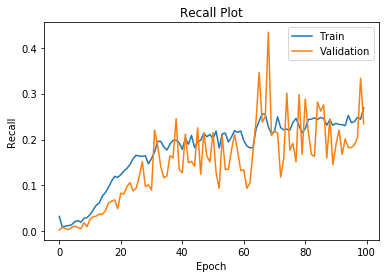

In [160]:
plt.plot(dropout_model.history.history['recall_8'])
plt.plot(dropout_model.history.history['val_recall_8'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

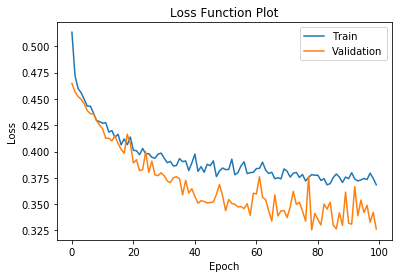

In [161]:
plt.plot(dropout_model.history.history['loss'])
plt.plot(dropout_model.history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [162]:
train_dropout_model_pred = dropout_model.predict_classes(X_train_proc_arr)
val_dropout_model_pred = dropout_model.predict_classes(X_val_proc_arr)

#### Getting evaluation metrics and evaluating model performance

In [163]:
### Calculate Accuracy, True Positive Rate and True Negative Rates

accuracy_score_train = accuracy_score(y_train, train_dropout_model_pred)
accuracy_score_val = accuracy_score(y_val, val_dropout_model_pred)

recall_score_train = recall_score(y_train, train_dropout_model_pred)
recall_score_val = recall_score(y_val, val_dropout_model_pred)

precision_score_train = precision_score(y_train, train_dropout_model_pred)
precision_score_val = precision_score(y_val, val_dropout_model_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-------------------------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8520365559473001
Train Recall:  0.25072738772928527
Train Precision:  0.8129614438063987
-------------------------------------
Val Accuracy:  0.8507874654976457
Val Recall:  0.24675324675324675
Val Precision:  0.803073967339097


#### Model with Batch Normalization

In [164]:
np.random.seed(123)
tf.random.set_seed(123)

In [165]:
bn_model = Sequential()

bn_model.add(Dense(25, 
                   input_dim=27, 
                   activation='relu', 
                   kernel_initializer="glorot_normal"))

bn_model.add(BatchNormalization())

bn_model.add(Dense(15, 
                   activation='relu', 
                   kernel_initializer="glorot_normal"))

bn_model.add(BatchNormalization())

bn_model.add(Dense(1, 
                   activation='sigmoid',
                   kernel_initializer="glorot_normal"))

In [166]:
bn_model.summary()

# https://stackoverflow.com/questions/42521005/how-the-number-of-parameters-associated-with-batchnormalization-layer-is-2048
# http://proceedings.mlr.press/v37/ioffe15.pdf


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 25)                700       
_________________________________________________________________
batch_normalization (BatchNo (None, 25)                100       
_________________________________________________________________
dense_76 (Dense)             (None, 15)                390       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15)                60        
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 16        
Total params: 1,266
Trainable params: 1,186
Non-trainable params: 80
_________________________________________________________________


In [167]:
bn_model.compile(loss='binary_crossentropy', 
                 optimizer='adam', 
                 metrics=[tf.keras.metrics.Recall()])

In [168]:
%%time
bn_model_history = bn_model.fit(X_train_proc_arr, 
                                y_train, 
                                epochs=100,
                                batch_size=best_params['best_batch_size'], 
                                validation_split=0.2)

Train on 34489 samples, validate on 8623 samples
Epoch 1/100
34489/34489 [==============================] - 3s 90us/sample - loss: 0.4737 - recall_9: 0.1115 - val_loss: 0.4712 - val_recall_9: 0.0419
Epoch 2/100
34489/34489 [==============================] - 2s 69us/sample - loss: 0.4221 - recall_9: 0.0947 - val_loss: 0.4343 - val_recall_9: 0.0594
Epoch 3/100
34489/34489 [==============================] - 2s 58us/sample - loss: 0.3963 - recall_9: 0.1445 - val_loss: 0.5352 - val_recall_9: 0.0237
Epoch 4/100
34489/34489 [==============================] - 2s 60us/sample - loss: 0.3766 - recall_9: 0.2002 - val_loss: 0.4256 - val_recall_9: 0.1556
Epoch 5/100
34489/34489 [==============================] - 2s 58us/sample - loss: 0.3680 - recall_9: 0.2436 - val_loss: 0.4688 - val_recall_9: 0.0312
Epoch 6/100
34489/34489 [==============================] - 2s 56us/sample - loss: 0.3560 - recall_9: 0.2928 - val_loss: 0.3824 - val_recall_9: 0.0988
Epoch 7/100
34489/34489 [==========================

#### Predictions

In [169]:
train_bn_model_pred = bn_model.predict_classes(X_train_proc_arr)
val_bn_model_pred = bn_model.predict_classes(X_val_proc_arr)

#### Getting evaluation metrics and evaluating model performance

In [170]:
### Calculate Accuracy, True Positive Rate and True Negative Rates

accuracy_score_train = accuracy_score(y_train, train_bn_model_pred)
accuracy_score_val = accuracy_score(y_val, val_bn_model_pred)

recall_score_train = recall_score(y_train, train_bn_model_pred)
recall_score_val = recall_score(y_val, val_bn_model_pred)

precision_score_train = precision_score(y_train, train_bn_model_pred)
precision_score_val = precision_score(y_val, val_bn_model_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-------------------------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8313926516979031
Train Recall:  0.10145477545857053
Train Precision:  0.8285123966942148
-------------------------------------
Val Accuracy:  0.8305460843210478
Val Recall:  0.09858323494687131
Val Precision:  0.8126520681265207


#### model with weight decay

#### Find the best Weight Decay value

In [171]:
from keras.regularizers import l2

Using TensorFlow backend.


In [172]:
weight_decay_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

In [173]:
weight_decay_list

[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]

In [174]:
%%time
def l2_model_func(l2_value):
    # Create model
    l2_model = Sequential()
    
    l2_model.add(Dense(25, 
                       input_dim=27, 
                       activation='relu', 
                       kernel_regularizer=l2(l2_value),
                       kernel_initializer="glorot_normal"))
    
    l2_model.add(Dropout(0.5))
    
    l2_model.add(Dense(15, 
                       activation='relu',
                       kernel_regularizer=l2(l2_value), 
                       kernel_initializer="glorot_normal"))
    
    l2_model.add(Dropout(0.5))
    
    l2_model.add(Dense(1, 
                       activation='sigmoid',
                       kernel_regularizer=l2(l2_value),
                       kernel_initializer="glorot_normal"))
    
    # Compile model
    l2_model.compile(loss='binary_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy'])
    
    return l2_model   

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 16.2 µs


In [175]:
%%time
hist_loss=[]

for weight_decay in weight_decay_list:
    
    np.random.seed(123)
    tf.random.set_seed(123)
    
    l2_model = l2_model_func(weight_decay)
    
    # Fit the model
    l2_model_history = l2_model.fit(X_train_proc_arr, 
                                    y_train, 
                                    epochs=1,
                                    validation_split=0.2,
                                    batch_size=64)
    
    hist_loss.append(l2_model_history.history['loss'])

Train on 34489 samples, validate on 8623 samples
34489/34489 [==============================] - 2s 48us/sample - loss: 1.7275 - accuracy: 0.7794 - val_loss: 0.5938 - val_accuracy: 0.8144
Train on 34489 samples, validate on 8623 samples
34489/34489 [==============================] - 2s 46us/sample - loss: 0.7182 - accuracy: 0.7865 - val_loss: 0.5374 - val_accuracy: 0.8144 accuracy: 0.78
Train on 34489 samples, validate on 8623 samples
34489/34489 [==============================] - 2s 51us/sample - loss: 0.5656 - accuracy: 0.7869 - val_loss: 0.4929 - val_accuracy: 0.8144
Train on 34489 samples, validate on 8623 samples
34489/34489 [==============================] - 2s 45us/sample - loss: 0.5377 - accuracy: 0.7862 - val_loss: 0.4712 - val_accuracy: 0.8144
Train on 34489 samples, validate on 8623 samples
34489/34489 [==============================] - 2s 45us/sample - loss: 0.5343 - accuracy: 0.7860 - val_loss: 0.4677 - val_accuracy: 0.8144
Train on 34489 samples, validate on 8623 samples
3

In [176]:
# Get the weight decay and loss Dataframe
loss_weight_decay = pd.DataFrame([weight_decay_list, hist_loss]).T  

#Give the coloumn names
loss_weight_decay.columns=['weight_decay', 'loss']

#Sort the values and reset the index
loss_weight_decay=loss_weight_decay.sort_values('loss').reset_index().drop('index',axis=1)
loss_weight_decay

,weight_decay,loss
0,1e-06,[0.533930339614556]
1,1e-05,[0.5342706240394524]
2,0.0001,[0.5377490600865537]
3,0.001,[0.565642666738423]
4,0.01,[0.7182207241532989]
5,0.1,[1.727495680750151]


In [177]:
#pick the top weight decay
best_params['best_l2_value'] = loss_weight_decay.loc[:,'weight_decay'][0]

In [178]:
best_params['best_l2_value']

1e-06

#### Build model with the best l2 value

In [179]:
np.random.seed(123)
tf.random.set_seed(123)

In [180]:
bst_l2_model = Sequential()

# Create model
bst_l2_model.add(Dense(25, 
                       input_dim=27, 
                       activation='relu', 
                       kernel_regularizer=l2(best_params['best_l2_value']),
                       kernel_initializer="glorot_normal"))

bst_l2_model.add(Dropout(0.5))

bst_l2_model.add(Dense(15, 
                       activation='relu',
                       kernel_regularizer=l2(best_params['best_l2_value']), 
                       kernel_initializer="glorot_normal"))

bst_l2_model.add(Dropout(0.5))

bst_l2_model.add(Dense(1, 
                       activation='sigmoid',
                       kernel_regularizer=l2(best_params['best_l2_value']), 
                       kernel_initializer="glorot_normal"))

# Compile model
bst_l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])

In [181]:
bst_l2_model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 25)                700       
_________________________________________________________________
dropout_14 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 15)                390       
_________________________________________________________________
dropout_15 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 16        
Total params: 1,106
Trainable params: 1,106
Non-trainable params: 0
_________________________________________________________________


In [182]:
bst_l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])

In [183]:
%%time
bst_l2_model_history = bst_l2_model.fit(X_train_proc_arr, 
                                        y_train, 
                                        epochs=100,
                                        batch_size=best_params['best_batch_size'], 
                                        validation_split=0.2, 
                                        shuffle=True)

Train on 34489 samples, validate on 8623 samples
Epoch 1/100
34489/34489 [==============================] - 3s 83us/sample - loss: 0.5133 - recall_11: 0.0328 - val_loss: 0.4648 - val_recall_11: 0.0031
Epoch 2/100
34489/34489 [==============================] - 3s 75us/sample - loss: 0.4721 - recall_11: 0.0087 - val_loss: 0.4568 - val_recall_11: 0.0088
Epoch 3/100
34489/34489 [==============================] - 2s 62us/sample - loss: 0.4597 - recall_11: 0.0114 - val_loss: 0.4512 - val_recall_11: 0.0056
Epoch 4/100
34489/34489 [==============================] - 2s 59us/sample - loss: 0.4554 - recall_11: 0.0125 - val_loss: 0.4488 - val_recall_11: 0.0031
Epoch 5/100
34489/34489 [==============================] - 2s 58us/sample - loss: 0.4492 - recall_11: 0.0146 - val_loss: 0.4450 - val_recall_11: 0.0088
Epoch 6/100
34489/34489 [==============================] - 2s 56us/sample - loss: 0.4426 - recall_11: 0.0209 - val_loss: 0.4381 - val_recall_11: 0.0106
Epoch 7/100
34489/34489 [==============

#### Predictions

In [184]:
train_bst_l2_model_pred = bst_l2_model.predict_classes(X_train_proc_arr)
val_bst_l2_model_pred = bst_l2_model.predict_classes(X_val_proc_arr)

#### Getting evaluation metrics and evaluating model performance

In [185]:
### Calculate Accuracy, True Positive Rate and True Negative Rates

accuracy_score_train = accuracy_score(y_train, train_bst_l2_model_pred)
accuracy_score_val = accuracy_score(y_val, val_bst_l2_model_pred)

recall_score_train = recall_score(y_train, train_bst_l2_model_pred)
recall_score_val = recall_score(y_val, val_bst_l2_model_pred)

precision_score_train = precision_score(y_train, train_bst_l2_model_pred)
precision_score_val = precision_score(y_val, val_bst_l2_model_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8444516607904992
Train Recall:  0.19468690702087288
Train Precision:  0.8190526875997871
-----------------------
Val Accuracy:  0.8422904151106781
Val Recall:  0.18742621015348288
Val Precision:  0.7977386934673367


**Best Parameters**

In [186]:
best_params

{'best_learning_rate': 0.1987,
 'best_batch_size': 32,
 'best_h_activation': 'relu',
 'best_kernel_init': 'glorot_normal',
 'best_optimizer': 'adam',
 'best_l2_value': 1e-06}

### Reference Links:

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://keras.io/